In [1]:
import scSpace
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
from sklearn.metrics import adjusted_rand_score
import random
import torch
import warnings
warnings.filterwarnings("ignore")

/home/qjy/anaconda3/envs/scspace_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    
setup_seed(100)

In [3]:
sc_data_dir = 'data/demo_sc_data.csv'
sc_meta_dir = 'data/demo_sc_meta.csv'
st_data_dir = 'data/demo_st_data.csv'
st_meta_dir = 'data/demo_st_meta.csv'
sc_obj, st_obj = scSpace.load_data(sc_data_path=sc_data_dir, sc_meta_path=sc_meta_dir, st_data_path=st_data_dir, st_meta_path=st_meta_dir)

Loading data...
Data have been loaded.


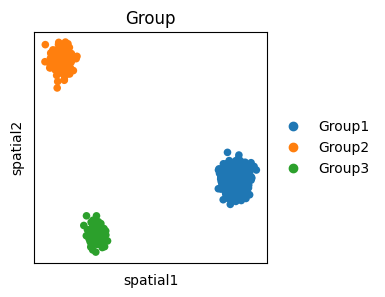

In [4]:
# ST reference 
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(st_obj, basis="spatial", color="Group")

In [5]:
sc_obj, st_obj = scSpace.preporcess(sc_adata=sc_obj, st_adata=st_obj, st_type='spot', n_features=2000, normalize=True)

Data have been pre-processed.


In [6]:
sc_obj, st_obj = scSpace.construct_pseudo_space(
    sc_adata=sc_obj,
    st_adata=st_obj,
    batch_size=128,
    activation='sigmoid',
    lr=0.001,
    epoch_num=1000,
    log_epoch=1000)

Beginning Transfer Component Analysis...
Transfer Component Analysis done.
Beginning training encoder for source domain...


100%|██████████| 1000/1000 [00:10<00:00, 97.71it/s]

Epoch [1000/1000]: Batch loss=3.8598999977111816
Encoder for source domain training finished.


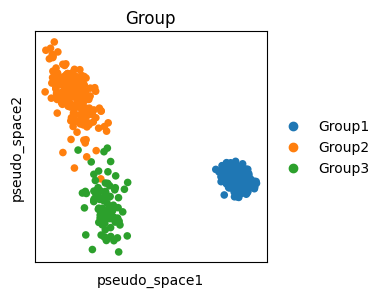

In [7]:
# Pseudo space of scRNA-seq 
sc.pl.embedding(sc_obj, basis="pseudo_space", color="Group")

In [8]:
# Spatial-informed clustering
sc_obj = scSpace.spatial_cluster(sc_obj, Ks=10, Kg=20, target_num=3)

Calculating spatial weights using the neighbours of spots...
Start at res =  0.5 step =  0.1
Res =  0.5 number of clusters =  2
Res =  0.6 number of clusters =  2
Res changed to 0.6
Res =  0.7 number of clusters =  3
Recommended res =  0.7


In [9]:
# UMAP visualization
sc.pp.neighbors(sc_obj)
sc.tl.umap(sc_obj)

In [10]:
# classic clustering method of scRNA-seq
sc.tl.leiden(sc_obj, resolution=0.9)

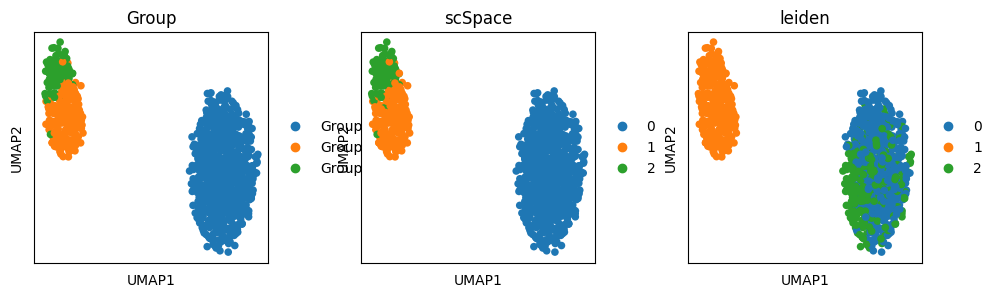

In [11]:
sc.pl.umap(sc_obj, color=['Group', 'scSpace', 'leiden'])

In [12]:
scspace_ari = adjusted_rand_score(sc_obj.obs['Group'], sc_obj.obs['scSpace'])
leiden_ari = adjusted_rand_score(sc_obj.obs['Group'], sc_obj.obs['leiden'])

print('ARI (scSpace):', scspace_ari, '\n', 'ARI (Leiden):', leiden_ari)

ARI (scSpace): 0.9941448107349248 
 ARI (Leiden): 0.4657143309286151
